In [57]:
#First, our imports

import os
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import shapiro

from sklearn import set_config
set_config(transform_output='pandas') #we don't need to do set_config if we don't 
                                      #care about our .transform outputting a data frame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
#We have loaded the CSV containing our data in the data folder under "pollution.csv" 
#Below we load it in:

df = pd.read_csv('data/pollution.csv')

In [59]:
#Now we get a very basic preview of it
df.head()

#notice that the place_ID and date appear in individual columns and a combined column
#according to the format of solutions for this task, we must use the column which has them
#combined

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#Check for missing target values
df['target'].isna().sum()

0

In [61]:
#Now make sure that the data type of the date column is datetime
#and then sort by date so we can analyze gaps

df['Date'] = pd.to_datetime(df['Date'])  # Ensure datetime format
df = df.sort_values('Date').set_index('Date')  # Sort and set index

In [62]:
#Now we want to see if there are any days that are missing
# Check the time index
full_time_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = full_time_index.difference(df.index)
print("Missing dates:", missing_dates)

#Great! There are no missing dates

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq=None)


Now we want to drop irrelevant features. These were decided before as:

columns containing solar, sensor, stratospheric, amf, slant, AND 

'L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure', 'L3_HCHO_cloud_fraction', 'L3_SO2_cloud_fraction',  'L3_NO2_cloud_fraction', 'L3_O3_cloud_fraction', 'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature', 'L3_CH4_aerosol_optical_depth', 'L3_CH4_aerosol_height','L3_CH4_CH4_column_volume_mixing_ratio_dry_air'


This was based on redundancy, irrelevance, and correlation. We also drop target columns other than target as these are correlated with the target column

In [63]:
drop_columms = ['L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_top_height', 
              'L3_CLOUD_cloud_top_pressure', 'L3_HCHO_cloud_fraction',
              'L3_SO2_cloud_fraction',  'L3_NO2_cloud_fraction', 'L3_O3_cloud_fraction',
              'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature', 
              'L3_CH4_aerosol_optical_depth', 'L3_CH4_aerosol_height', 
              'L3_CH4_CH4_column_volume_mixing_ratio_dry_air', 'Place_ID X Date', 'target_min',
              'target_max', 'target_variance', 'target_count']
df_cleaned = df.drop(columns=drop_columms)
df_transformed = df_cleaned[df_cleaned.columns[~df_cleaned.columns.str.contains
                                               ('solar|sensor|stratospheric|amf|slant', case=False)]]

#Only 23 columns remain and one of them is target!

<Axes: >

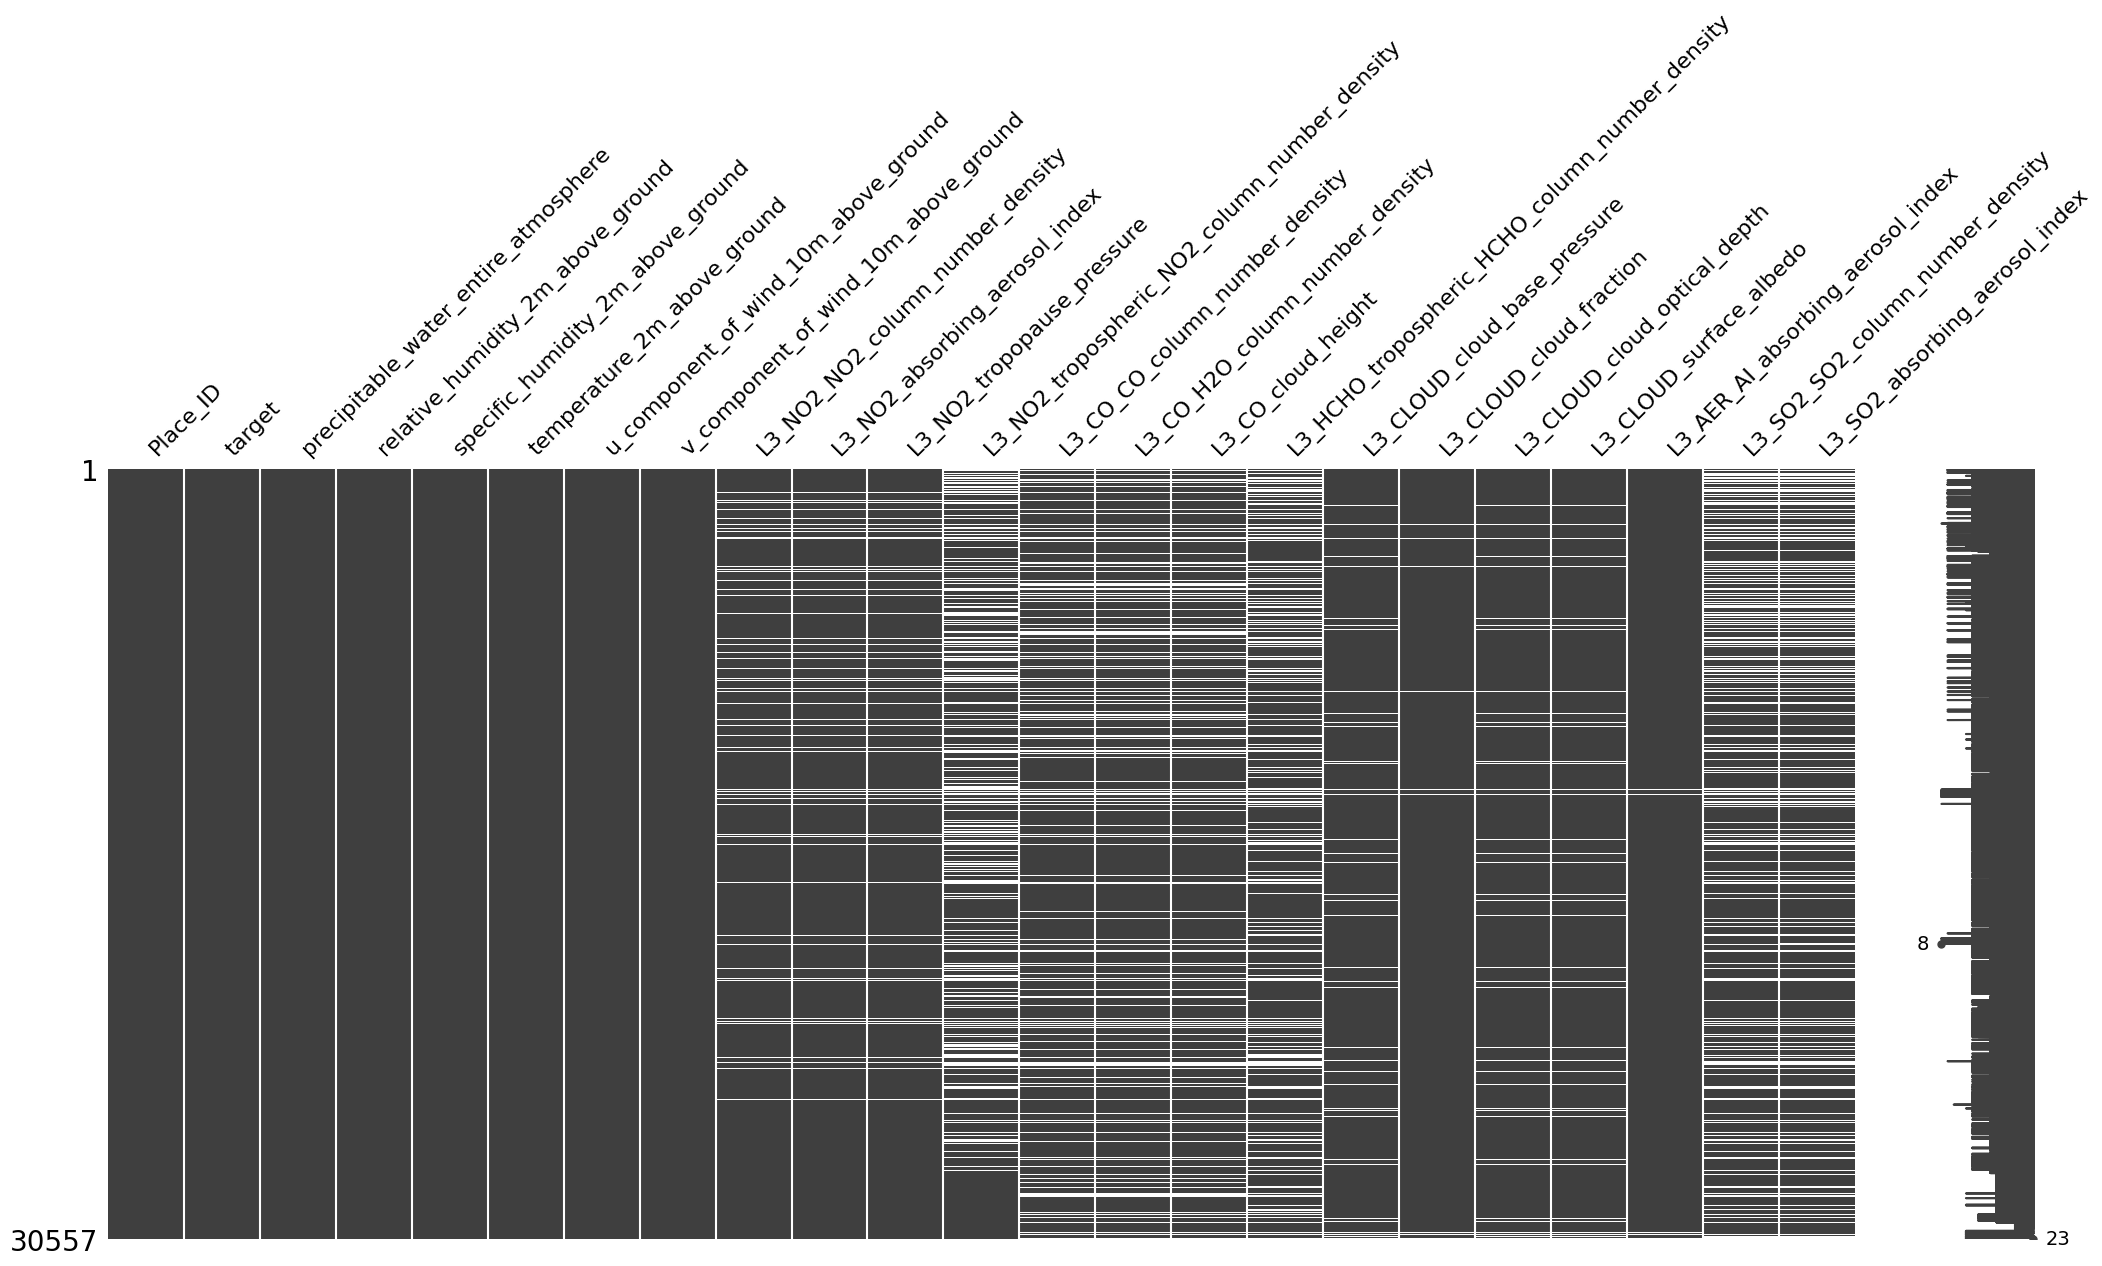

In [64]:
#We now use missingno to look for patterns in missing data

import missingno as msno
msno.matrix(df_transformed)

## Handle gaps and missing dates

In [65]:
full_time_index = pd.date_range(start=df_transformed.index.min(), 
                                end=df_transformed.index.max(), freq='D')  # Change 'D' for daily frequency
missing_dates = full_time_index.difference(df_transformed.index)
print("Missing dates:", missing_dates)

#There are no missing dates

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq=None)


## Train-test split

At this point we have looked at the necessary stuff, removed the irrelevant columns, and now it comes time to do some interploation etc. We only want to do this based on the training data so it's important that at this point we spit the data. For time-series we split not randomly, but by date. For example, below we take the first 80% of the data and predict on the last 20% (which is determined sequentially). This split ensures that your test set is "in the future" compared to your training set, maintaining proper chronological order.

In [66]:
train_size = int(len(df_transformed) * 0.8)  # 80% for training
X_train, X_test = df_transformed[:train_size], df_transformed[train_size:]

### Create time-based features

In [67]:
import warnings
warnings.filterwarnings('ignore')
# For training set
X_train['day_of_week'] = X_train.index.dayofweek
X_train['is_weekend'] = X_train['day_of_week'] >= 5
X_train['month'] = X_train.index.month


# For test set (same features, applied separately to test set)
X_test['day_of_week'] = X_test.index.dayofweek
X_test['is_weekend'] = X_test['day_of_week'] >= 5
X_test['month'] = X_test.index.month

## Interpolation (time-based imputation)

For time-series data, it's common to use interpolation, forward-fill, or backward-fill.
For pollutants or continuous features, interpolation is often suitable.
(For categorical variables, use mode or forward-fill.) This is done separately for the training and the test data so that no information is taken from each other

In [68]:
X_train = X_train.interpolate(method='time')
X_test = X_test.interpolate(method='time')

## Deal with Place/Categorical Data

When checking the number of unique values in the Place_ID column, there were 340.

This data is relevant but we need to find a way to encode it that's meaningful but not too computationally heavy. One-hot encoding would create 340 new columns which is way too many and ordinal encoding runs the risk of misunderstanding the relationship.

Thus we use an encoding method called "target encoding". This is best when you suspect that place_id has a meaningful relationship with the target variable (e.g., pollution levels). How it works:

* you replace the place_id with the mean of the target variable (e.g., pollution levels) for each place. 


This can work well when there are many categories, and the relationship between the category and the target is meaningful. It reduces the dimensionality and also can capture category-target relationships.

Target encoding is calculated only on the TRAINING data to ensure that no future information (from the test set) influences the encoding process. The test set will then use the target encoding learned from the training set without leakage.

In [70]:
# Perform target encoding on 'place_id' for both training and test sets
# Ensure the encoder is fit on the training set only to avoid leakage
place_id_encoder = X_train.groupby('Place_ID')['target'].mean()

# Apply the encoding to both train and test sets
X_train['place_id_encoded'] = X_train['Place_ID'].map(place_id_encoder)
X_test['place_id_encoded'] = X_test['Place_ID'].map(place_id_encoder)

# Check if any missing values exist
print(X_test['place_id_encoded'].isnull().sum())

7


In [71]:
#There are 7 missing values for the place_id_encoded in X_test so for now 
# i will fill them with the global mean. This does not seem ideal so I 
# want to take a look later at how to do this better

# Compute the global mean of place_id_encoded from the training set
global_mean = X_train['place_id_encoded'].mean()

# Fill missing place_id_encoded values in the test set with the global mean
X_test['place_id_encoded'].fillna(global_mean, inplace=True)

# Verify that there are no more missing values
print(X_test['place_id_encoded'].isnull().sum())  # Should print 0

0


## Create lag features

Now I create lag features:

For autoregressive modeling, you need to create lag features that track past values of the target variable. These help the model learn patterns in the historical data. Here lag_1 means target value from 1 day ago and lag 2 means target value from 2 days ago.

This occurs after encoding and imputation because lag features rely on previous values. You want to ensure that you are creating them using the correctly encoded features and fully imputed data. Creating lag features after encoding also ensures the encoded version of place_id is included in the lag features, making them useful for modeling.

In [72]:
# Create lag features for training set
X_train['lag_1'] = X_train['target'].shift(1)
X_train['lag_2'] = X_train['target'].shift(2)

# Create lag features for test set (same shifts applied to test set)
X_test['lag_1'] = X_test['target'].shift(1)
X_test['lag_2'] = X_test['target'].shift(2)

## Feature selection / Removing Redundancies

At this point, the Place_ID feature is redundant. We already dropped target min/max/variance etc. so for now we only drop this Place_ID column.

In [73]:
# Drop unnecessary columns
X_train = X_train.drop(columns=['Place_ID'])
X_test = X_test.drop(columns=['Place_ID'])

### Scaling / Normalization (Optional)

In [39]:
#See if i want to implement this later

## Model

In [74]:
from statsmodels.tsa.arima.model import ARIMA

#We want to make sure that our model takes into account the place_ID since this is relevant

train_place = X_train[['place_id_encoded']]  # Exogenous variable for training
test_place = X_test[['place_id_encoded']]   # Exogenous variable for testing


# Fit an ARIMA model (example: AR(1), I(1), MA(1))
ts_model = ARIMA(X_train['target'], order=(1,1,1), exog=train_place)
ts_model_fit = ts_model.fit()

# Forecast the future values
ts_forecast = ts_model_fit.forecast(steps=len(X_test), exog=test_place)

In [75]:
# Compare forecasted values to the actual values in the test set
y_true = X_test['target']  # Actual values
y_pred = ts_forecast  # Predicted values

# Compute Mean Squared Error (MSE) and then RMSE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Output the RMSE
print(f'RMSE: {rmse}')

RMSE: 28.49029019913257
